# Energy Usage Analysis: Fixed vs Economy 7 Tariff Comparison

## Summary

This analysis examines household electricity consumption data to determine whether an **Economy 7 (day/night) tariff** is more cost-effective than a **fixed-rate tariff**. The data covers 8 months (May - December 2025) with half-hourly readings totalling 11,762 records.

### Key Findings

- **Total savings over the period of £226.81** by using the variable day/night tariff instead of a fixed rate
- The Economy 7 tariff is beneficial when **night-time usage exceeds 39%** of total consumption
- Night-time usage never fell below 50%
- All months analysed showed positive savings, with December showing the largest benefit (£75.83)

## Analysis Walkthrough

### Step 1: Data Loading and Initial Exploration

The analysis uses **DuckDB** for SQL-based data manipulation and **matplotlib** for visualisation. The raw data contains:
- `Consumption (kwh)` – energy used per 30-minute interval
- `Estimated Cost Inc. Tax (p)` – cost in pence
- `Start` / `End` – timestamps for the start and end of each reading period

In [83]:
import duckdb
import matplotlib.pyplot as plt

con = duckdb.connect()

con.sql("SELECT * FROM 'energy.csv' LIMIT 5").show()

┌───────────────────┬─────────────────────────────┬──────────────────────────┬──────────────────────────┐
│ Consumption (kwh) │ Estimated Cost Inc. Tax (p) │          Start           │           End            │
│      double       │           double            │ timestamp with time zone │ timestamp with time zone │
├───────────────────┼─────────────────────────────┼──────────────────────────┼──────────────────────────┤
│             0.064 │                   2.0906592 │ 2025-05-01 00:00:00+01   │ 2025-05-01 00:30:00+01   │
│             0.067 │                  2.18865885 │ 2025-05-01 00:30:00+01   │ 2025-05-01 01:00:00+01   │
│             0.073 │                  2.38465815 │ 2025-05-01 01:00:00+01   │ 2025-05-01 01:30:00+01   │
│             0.056 │                  0.77290836 │ 2025-05-01 01:30:00+01   │ 2025-05-01 02:00:00+01   │
│             0.073 │                 1.007541255 │ 2025-05-01 02:00:00+01   │ 2025-05-01 02:30:00+01   │
└───────────────────┴─────────────────────────

In [84]:
con.sql("""
SELECT * FROM 'energy.csv' LIMIT 5
""").show()

┌───────────────────┬─────────────────────────────┬──────────────────────────┬──────────────────────────┐
│ Consumption (kwh) │ Estimated Cost Inc. Tax (p) │          Start           │           End            │
│      double       │           double            │ timestamp with time zone │ timestamp with time zone │
├───────────────────┼─────────────────────────────┼──────────────────────────┼──────────────────────────┤
│             0.064 │                   2.0906592 │ 2025-05-01 00:00:00+01   │ 2025-05-01 00:30:00+01   │
│             0.067 │                  2.18865885 │ 2025-05-01 00:30:00+01   │ 2025-05-01 01:00:00+01   │
│             0.073 │                  2.38465815 │ 2025-05-01 01:00:00+01   │ 2025-05-01 01:30:00+01   │
│             0.056 │                  0.77290836 │ 2025-05-01 01:30:00+01   │ 2025-05-01 02:00:00+01   │
│             0.073 │                 1.007541255 │ 2025-05-01 02:00:00+01   │ 2025-05-01 02:30:00+01   │
└───────────────────┴─────────────────────────

### Step 2: Classifying Day vs Night Periods

A view is created to categorise each reading as 'day' or 'night' based on Economy 7 timing rules. The night period differs between summer (BST) and winter (GMT):

- **Summer (30 Mar – 26 Oct):** Night = 01:30 to 08:30
- **Winter:** Night = 00:30 to 07:30

In [85]:
con.sql("""
CREATE OR REPLACE VIEW energy_with_period AS
    WITH energy_base AS (
    SELECT 
        "Consumption (kwh)" as consumption,
        "Estimated Cost Inc. Tax (p)" as cost,
        "Start"::TIMESTAMP as start,
        "End"::TIMESTAMP as end
    FROM 'energy.csv'
)


    SELECT
        *,
        CASE
            WHEN start >= '2025-03-30' AND start <= '2025-10-26' THEN
                CASE
                    WHEN start::TIME >= '01:30' AND start::TIME < '08:30' THEN 'night' ELSE 'day' END
            ELSE
                CASE
                    WHEN start::TIME >= '00:30' AND start::TIME < '07:30' THEN 'night' ELSE 'day' END
        END as day_night
    FROM energy_base

""")

con.sql("""SELECT * from energy_with_period""").show()

┌─────────────┬──────────────┬─────────────────────┬─────────────────────┬───────────┐
│ consumption │     cost     │        start        │         end         │ day_night │
│   double    │    double    │      timestamp      │      timestamp      │  varchar  │
├─────────────┼──────────────┼─────────────────────┼─────────────────────┼───────────┤
│       0.064 │    2.0906592 │ 2025-05-01 00:00:00 │ 2025-05-01 00:30:00 │ day       │
│       0.067 │   2.18865885 │ 2025-05-01 00:30:00 │ 2025-05-01 01:00:00 │ day       │
│       0.073 │   2.38465815 │ 2025-05-01 01:00:00 │ 2025-05-01 01:30:00 │ day       │
│       0.056 │   0.77290836 │ 2025-05-01 01:30:00 │ 2025-05-01 02:00:00 │ night     │
│       0.073 │  1.007541255 │ 2025-05-01 02:00:00 │ 2025-05-01 02:30:00 │ night     │
│       1.569 │ 21.655236015 │ 2025-05-01 02:30:00 │ 2025-05-01 03:00:00 │ night     │
│       3.096 │  42.73079076 │ 2025-05-01 03:00:00 │ 2025-05-01 03:30:00 │ night     │
│       1.767 │ 24.388019145 │ 2025-05-01 0

### Step 3: Monthly Cost Breakdown

Costs are aggregated by month, split between day and night periods:

In [86]:
cost_df = con.sql("""        
SELECT
        EXTRACT(month from start) as month,
        SUM(CASE WHEN day_night == 'day' THEN cost/100 END) day_cost,
        SUM(CASE WHEN day_night == 'night' THEN cost/100 END) as night_cost
        FROM energy_with_period
        GROUP BY month
        ORDER BY month
""").df()



month_map = {1:'Jan',
             2:'Feb',
             3:'Mar',
             4:'Apr',
             5:'May',
             6:'Jun',
             7:'Jul',
             8:'Aug',
             9:'Sep',
             10:'Oct',
             11:'Nov',
             12:'Dec'}

month_name = cost_df['month'].map(month_map)
cost_df.insert(0,'Month',month_name)
cost_df

,Month,month,day_cost,night_cost
0,May,5,75.113792,53.658749
1,Jun,6,62.722389,45.208100
2,Jul,7,78.139368,47.367689
3,Aug,8,77.177338,43.494176
4,Sep,9,88.293438,51.628622
5,Oct,10,117.209541,56.469222
6,Nov,11,164.396046,80.136657
7,Dec,12,144.980356,135.394222


A stacked bar chart visualises this breakdown, showing how costs increase significantly in winter months.

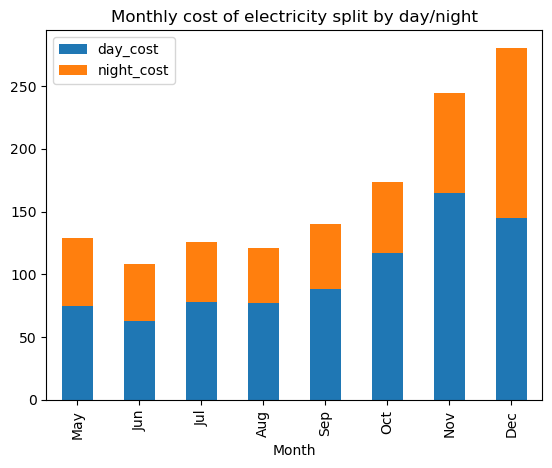

In [87]:
cost_df.plot(x='Month',y=['day_cost','night_cost'],stacked=True,kind='bar')
plt.title('Monthly cost of electricity split by day/night')
plt.show()

It is useful to visualise what percentage of the cost was coming from the day/night usage:

<Axes: xlabel='Month'>

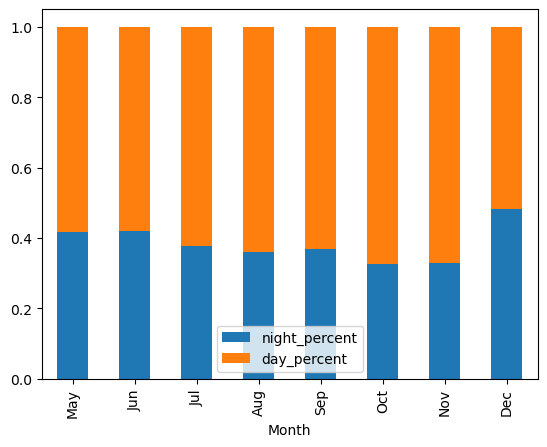

In [88]:
cost_proportion_df = con.sql("""
WITH monthly_cost AS (
    SELECT    
        EXTRACT(month from start) as month,
        SUM(CASE WHEN day_night = 'day' THEN cost/100 END) as day_cost,
        SUM(CASE WHEN day_night = 'night' THEN cost/100 END) as night_cost,
        SUM(cost/100) as total_cost
        FROM energy_with_period
        GROUP BY month
        ORDER BY month
    ) 
SELECT
        month,
        day_cost/total_cost as day_percent,
        night_cost/total_cost as night_percent
        FROM monthly_cost
        ORDER BY month
""").df()

cost_proportion_df.insert(0,'Month',month_name)
cost_proportion_df.plot(x='Month',y=['night_percent','day_percent'],stacked=True,kind='bar')

### Step 4: Break-Even Analysis

The tariff rates are as follows:

| Tariff Type | Day Rate | Night Rate |
|-------------|----------|------------|
| Fixed | 25p/kWh | 25p/kWh |
| Economy 7 | 32p/kWh | 14p/kWh |

To calculate the break-even point:

Economy 7 cost: 32(1-n) + 14n  where n = night usage proportion
Fixed cost: 25

Break-even when: 32(1-n) + 14n < 25
Solving: 18n > 7
Result: n > 7/18 ≈ 39%


**The Economy 7 tariff becomes worthwhile when more than 39% of usage occurs during night hours.**

### Step 5: Usage Proportion Analysis

The proportion of energy used during day vs night is calculated for each month:

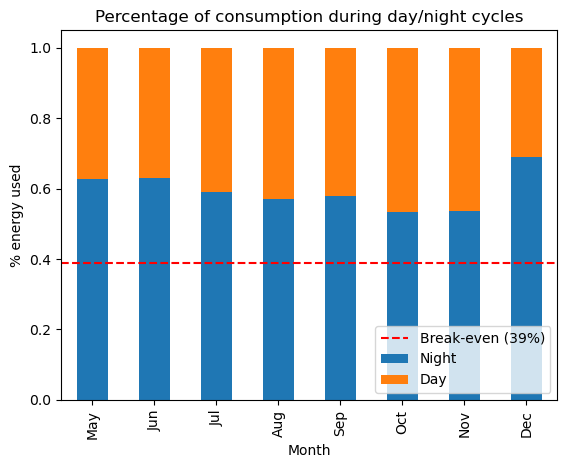

In [89]:
usage_proportion_df = con.sql("""
WITH monthly_usage AS (
    SELECT    
        EXTRACT(month from start) as month,
        SUM(CASE WHEN day_night = 'day' THEN consumption END) as day_usage,
        SUM(CASE WHEN day_night = 'night' THEN consumption END) as night_usage,
        SUM(consumption) as total_usage
        FROM energy_with_period
        GROUP BY month
        ORDER BY month
)
    
SELECT
        month,
        day_usage/total_usage as day_percent,
        night_usage/total_usage as night_percent
        FROM monthly_usage
        ORDER BY month
""").df()

usage_proportion_df.insert(0,'Month',month_name)
ax = usage_proportion_df.plot(x='Month',y=['night_percent','day_percent'],stacked=True,kind='bar')
ax.set_ylabel('% energy used')
ax.axhline(y=0.39, color='red', linestyle='--', label='Break-even if night % is above this (39%)')
ax.legend(labels=['Break-even (39%)','Night','Day'],loc='lower right')
plt.title('Percentage of consumption during day/night cycles')
plt.show()

In [90]:
usage_df = con.sql("""
    SELECT    
        EXTRACT(month from start) as month,
        SUM(CASE WHEN day_night = 'day' THEN consumption END) as day_usage,
        SUM(CASE WHEN day_night = 'night' THEN consumption END) as night_usage,
        SUM(consumption) as total_usage
        FROM energy_with_period
        GROUP BY ROLLUP(month)
        ORDER BY month

""").df()

usage_df.insert(0,'Month',month_name)
usage_df

,Month,month,day_usage,night_usage,total_usage
0,May,5,229.941,388.777,618.718
1,Jun,6,192.008,327.549,519.557
2,Jul,7,239.203,343.196,582.399
3,Aug,8,236.258,315.131,551.389
4,Sep,9,270.287,374.068,644.355
5,Oct,10,358.806,408.913,767.719
6,Nov,11,503.255,580.619,1083.874
7,Dec,12,443.819,980.980,1424.799
8,NaN,<NA>,2473.577,3719.233,6192.810


### Step 7: Final Cost Comparison

The total costs under both tariff types are compared:


In [91]:
total_variable_cost = cost_df['day_cost'].sum() + cost_df['night_cost'].sum()
total_fixed_cost = usage_df['total_usage'].iloc[-1] * 0.25
saving =  total_fixed_cost - total_variable_cost

print(f'Total cost over tenancy using variable cost: £{total_variable_cost:.2f}')
print(f'Total cost over tenancy if we used fixed cost: £{total_fixed_cost:.2f}')
print(f'Total saving: £{saving:.2f}')

Total cost over tenancy using variable cost: £1321.39
Total cost over tenancy if we used fixed cost: £1548.20
Total saving: £226.81


  Month  month  total_variable_cost  total_fixed_cost  saving
0   May      5               128.77            154.68   25.91
1   Jun      6               107.93            129.89   21.96
2   Jul      7               125.51            145.60   20.09
3   Aug      8               120.67            137.85   17.18
4   Sep      9               139.92            161.09   21.17
5   Oct     10               173.68            191.93   18.25
6   Nov     11               244.53            270.97   26.44
7   Dec     12               280.37            356.20   75.83


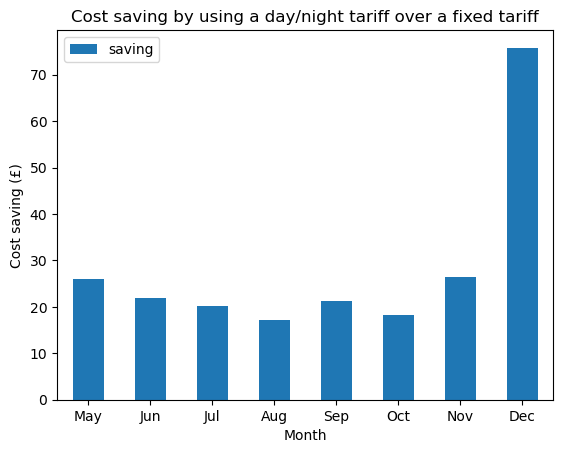

In [92]:
cost_comparison_df = con.sql("""        
SELECT
        EXTRACT(month from start) as month,
        ROUND(SUM(cost/100),2) as total_variable_cost,
        ROUND(SUM(consumption * 0.25),2) as total_fixed_cost,
        ROUND(SUM(consumption * 0.25) - SUM(cost/100),2) as saving
        FROM energy_with_period
        GROUP BY month
        ORDER BY month

""").df()

cost_comparison_df.insert(0,'Month',month_name)
print(cost_comparison_df)
cost_comparison_df.plot(x='Month',y=['saving'],kind='bar')
plt.title('Cost saving by using a day/night tariff over a fixed tariff')
plt.xticks(rotation=0)
plt.ylabel('Cost saving (£)')
plt.show()

## Conclusions

1. **The Economy 7 tariff provides consistent savings** across all months analysed

2. **December shows the greatest benefit** due to high overnight heating usage (storage heaters)

4. **Annual projection:** If this pattern continues, annual savings could exceed **£400**, when accounting for increased savings in the winter months

### Recommendations

- Continue with the Economy 7 tariff